In [2]:
import numpy as np
import pandas as pd
import gudhi as gd
import sys
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import os
import persim
import persim
from Topo import *

import torch
from gudhi.representations.vector_methods import PersistenceImage
from sklearn.manifold import TSNE

import igraph as ig

In [3]:
fname = "xbar1_clique"
data = torch.load(f"/data/{fname}.pt")

In [4]:
pos_lst = data.loc.tolist()
pos = {idx: pos_lst[idx] for idx in range(data.num_nodes)}

In [5]:
# prepare the need files: 1. edgelist 2. networkx graph
edgelist = data.edge_index.T.tolist()
G = nx.DiGraph(edgelist)
nodelist = list(G.nodes())

In [6]:
from matplotlib import pylab
import networkx as nx

def save_graph(graph, pos, file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

In [7]:
def gen_local_pd(G, s_n, radius):
    sub_g = nx.ego_graph(G, s_n, radius)
    edgs = list(sub_g.edges)
    n = sub_g.number_of_nodes()
    idx_dict = {list(sub_g.nodes)[idx]:idx for idx in range(n)}
    all_dist_raw = []
    edgs_d = [(idx_dict[lst[0]], idx_dict[lst[1]], 1) for lst in edgs] 
    graph = Graph(edgs_d, n)
    loc_delay_dict = findLongestDistance(graph, idx_dict[s_n], n)
    loc_delay_dict = {key: loc_delay_dict[key].pop() for key in loc_delay_dict.keys()}
    d_lst = []
    for delay in range(max(loc_delay_dict.values()) + 1):
        delay_level_lst = []
        for node in loc_delay_dict.keys():
            if loc_delay_dict[node] == delay:
                delay_level_lst.append(node)

        if len(delay_level_lst) == 0:
            continue
        d_lst.append(delay_level_lst)
    to_level = len(d_lst) 
    st = gd.SimplexTree()

    edgs = [(idx_dict[edg[0]], idx_dict[edg[1]]) for edg in edgs]
    for edg in edgs:
        st.insert(edg)


    for delay in range(to_level):
        nodes = d_lst[delay]
        for node in nodes:
            st.assign_filtration([node], delay)

    st.extend_filtration()
    dgms = st.extended_persistence()
    dgms = np.array([list([tp[1][-1], tp[1][0]]) for tp in dgms[3]])
    return dgms

In [8]:
dgm_lst = []
for s_n in nodelist:
    dgm_lst.append(gen_local_pd(G, s_n, 3))

KeyboardInterrupt: 

In [242]:
np.save("dgm_lst.npy", dgm_lst)

/home/zluo/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [8]:
dgm_lst = np.load("dgm_lst.npy", allow_pickle=True)

In [33]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
f = plt.figure(figsize=[10, 10])
nx.draw(G, pos=pos, ax=f.add_subplot(111), node_size=1, width=1)
f.savefig("graph.png")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x15548f546430> (for post_execute):


KeyboardInterrupt: 

In [239]:
#Wasserstein distances between each PD. SUPER EXPENSIVE 

w_d_lst = []
for idx1 in range(len(nodelist)):
    dgm1 = dgm_lst[idx1]
    inner_lst = []
    for idx2 in range(idx1, len(nodelist)):
        dgm2 = dgm_lst[idx2]
        inner_lst.append(persim.sliced_wasserstein(dgm1, dgm2, M=50))

    w_d_lst.append(inner_lst)
    if idx1//500 > 0 and idx1%500 == 0:
        print(idx1)
        np.save("w_d_lst_1.npy", w_d_lst)

np.save("w_d_lst_1.npy", w_d_lst)

KeyboardInterrupt: 

In [9]:
for idx in range(len(dgm_lst)):
    dgm = dgm_lst[idx]
    if len(dgm) == 0:
        dgm_lst[idx] = np.array([[0., 0.]])

In [10]:
L = PersistenceImage().fit_transform(dgm_lst)

MemoryError: Unable to allocate 366. MiB for an array with shape (23961200, 2) and data type float64

In [70]:
X_embedded = TSNE(n_components=2, init='random', perplexity=100.0, n_iter=1000).fit_transform(L)

In [172]:
x = [pt[0] for pt in X_embedded]
y = [pt[1] for pt in X_embedded]
#z = [pt[2] for pt in X_embedded]

In [195]:
Y = []
for node in nodelist:
    c_tp = data.y[node]
    c = c_tp[0]/c_tp[1]
    Y.append(float(c))

In [196]:
sorted_list = sorted(np.unique(Y))
idx_lst = [sorted_list.index(Y[idx]) for idx in range(len(Y))]

In [197]:
pal = ig.drawing.colors.AdvancedGradientPalette(["green", "yellow", "red"], n=int(len(sorted_list)*1))
pal = list(pal)
#pal = [(0, 0, 0, 0) for idx in range(int(len(sorted_list)*0.75))] + pal

In [198]:
color_lst = [pal[idx] for idx in idx_lst]

In [160]:
np.save("color.npy", color_lst)

In [161]:
edge_color = []
for edge in data.edge_index.T:
    edge = edge.tolist()
    source = edge[0]
    color = color_lst[source]
    edge_color.append(color)

In [162]:
np.save("edge_color.npy", edge_color)

In [129]:
import plotly.express as px
import pandas as pd
from sklearn.cluster import KMeans

In [173]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['color'] = color_lst

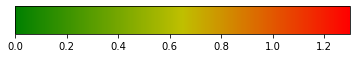

In [200]:
from  matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap=LinearSegmentedColormap.from_list('rg',["g", "y", "r"], N=len(sorted_list)) 
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=1.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

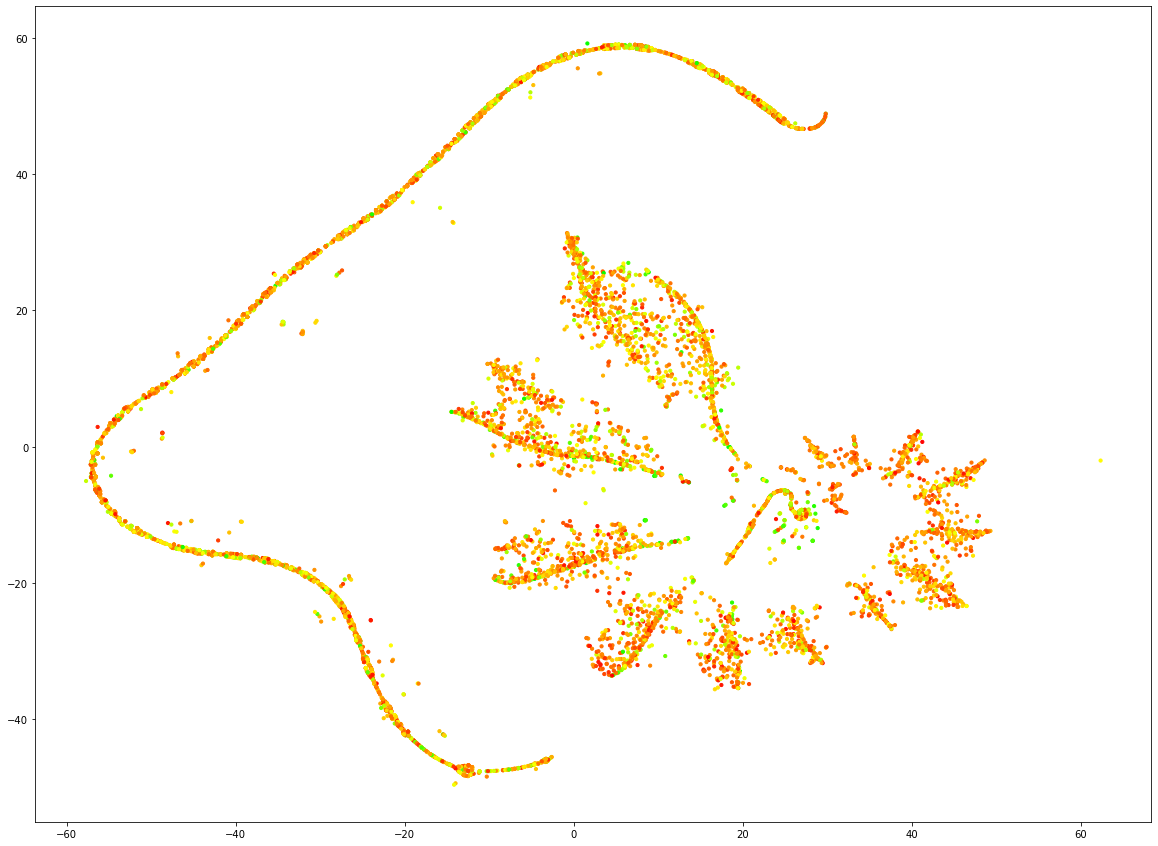

In [132]:
plt.figure(figsize=[20, 15])
p = plt.scatter(x=x, y=y, color=color_lst, s=10)

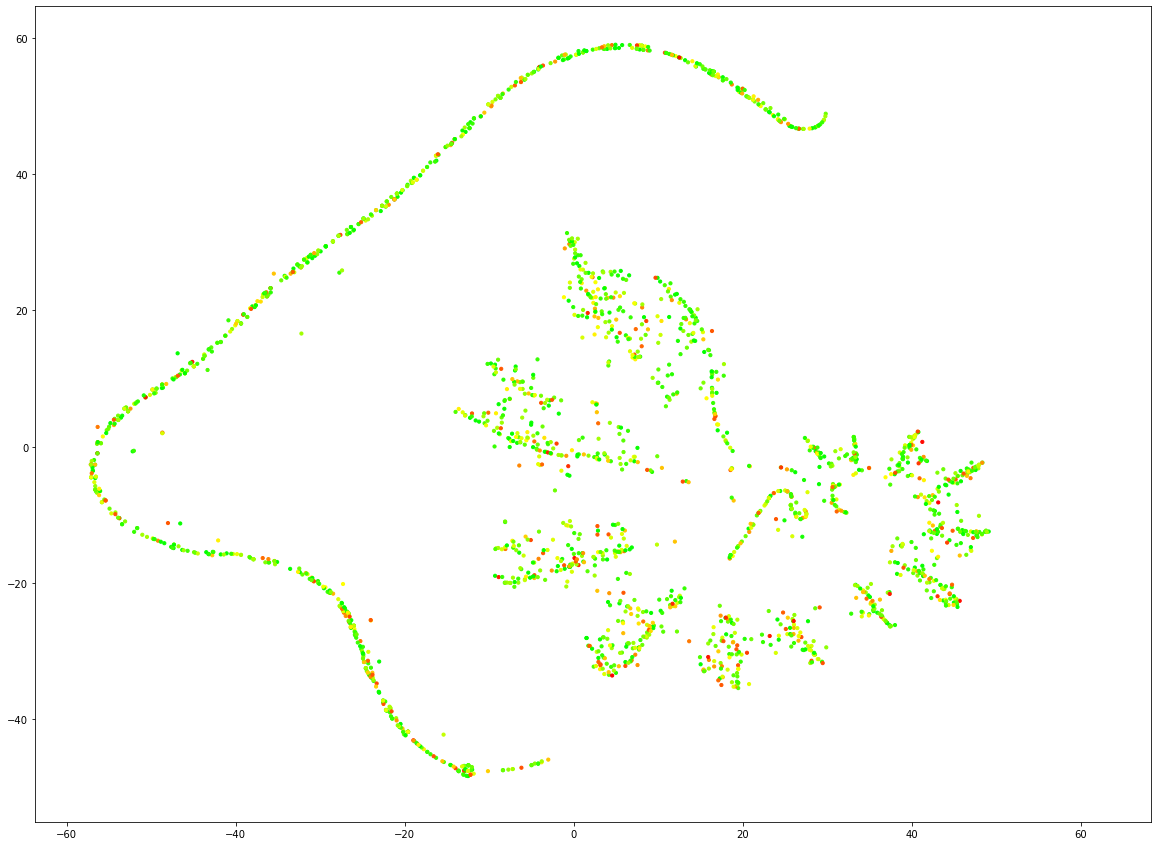

In [174]:
plt.figure(figsize=[20, 15])
p = plt.scatter(x=x, y=y, color=color_lst, s=10)

In [178]:
np.save("L.npy", L)

In [179]:
embedding = np.load("embedding.npy")
embedding

array([[ 3.8371658 ,  9.507043  ],
       [13.702032  ,  5.0993977 ],
       [10.729283  ,  8.969828  ],
       ...,
       [-5.4105363 ,  0.99436605],
       [-4.0490594 , 17.75336   ],
       [ 2.4501488 ,  8.389931  ]], dtype=float32)

In [180]:
x = [pt[0] for pt in embedding]
y = [pt[1] for pt in embedding]

In [181]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['color'] = color_lst

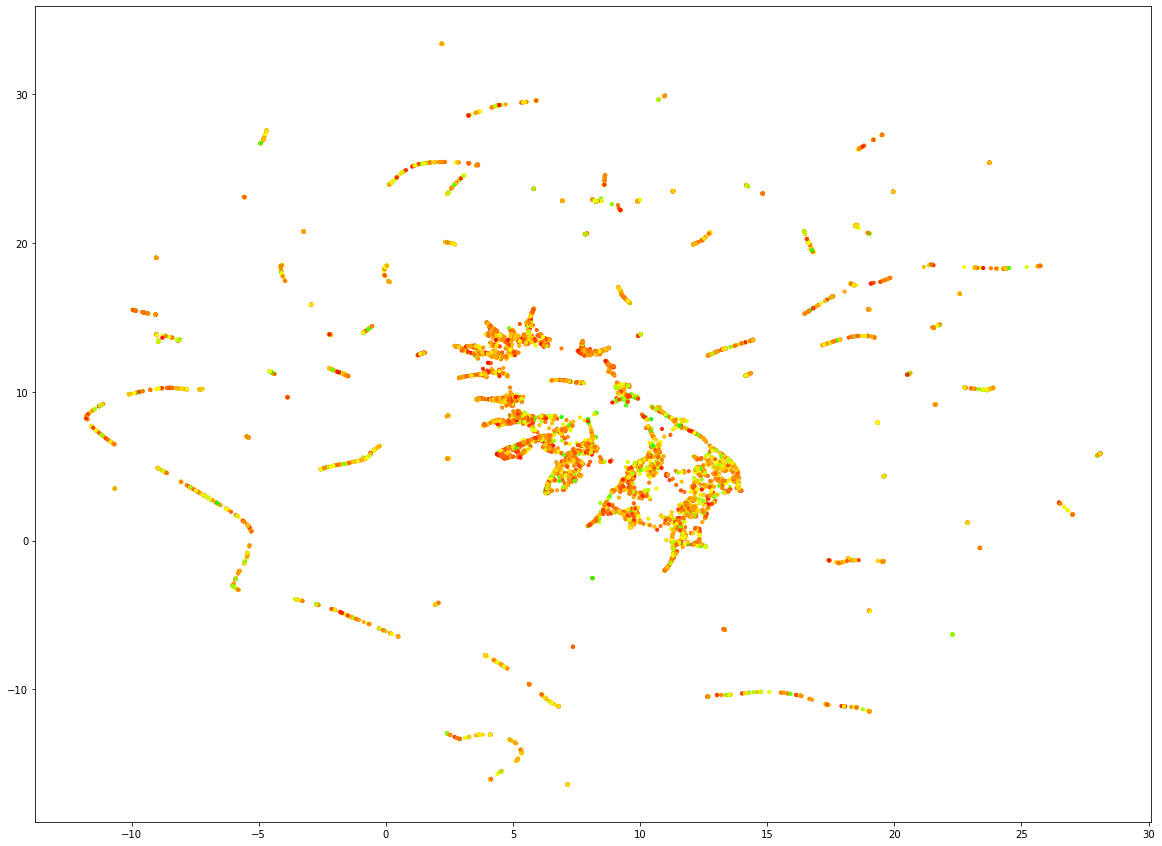

In [199]:
plt.figure(figsize=[20, 15])
p = plt.scatter(x=x, y=y, color=color_lst, s=10)

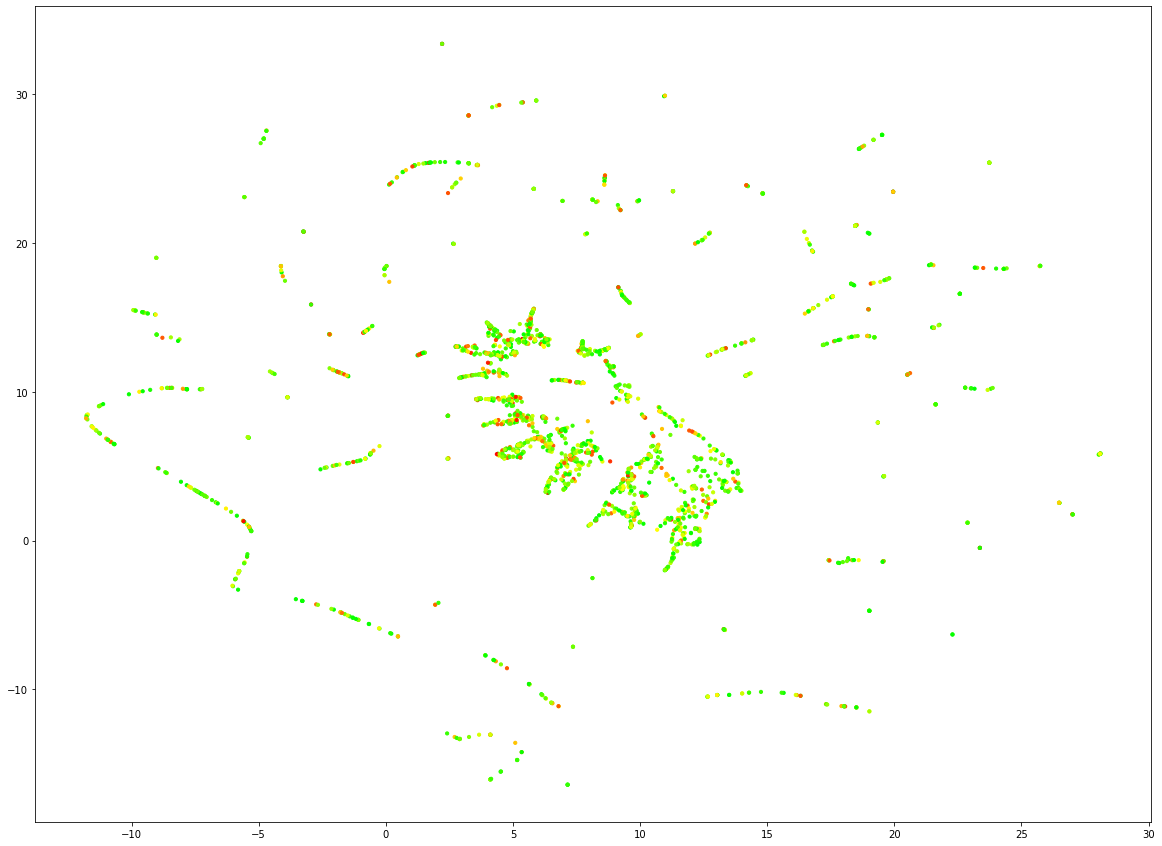

In [182]:
plt.figure(figsize=[20, 15])
p = plt.scatter(x=x, y=y, color=color_lst, s=10)